# QPINN for solving the PDE in Portfolio Optimization

### Import packages

In [2]:
import matplotlib.pyplot as plt
from matplotlib.ticker import LogLocator, FuncFormatter
import torch
import torch.nn as nn
from torch.autograd import grad
import pennylane as qml
import torch_optimizer as optim
import numpy as np
from matplotlib import rcParams

### Train QPINN, PINN, and Counterpart PINN

In [14]:
# ===============================
# HJB parameters
# ===============================
r = 0.02
T = 1.0
mu = 0.0219
gamma = 0.95
sigma = 0.20
k = -gamma * r + 0.5 * (gamma/(gamma-1)) * ((mu - r)/sigma)**2
x_layer1 = 1
x_layer2 = 2
t_layer1 = 1
t_layer2 = 2
scale = 10

torch.set_default_dtype(torch.float64)
n_wires = 5
dev = qml.device("default.qubit", wires=n_wires)

# ===============================
# 🧩 Sampling + Utility
# ===============================
def sample_collocation(n):
    t = torch.linspace(0.01, 0.99, n).unsqueeze(1)
    x = torch.linspace(0.01, 0.99, n).unsqueeze(1)
    return t, x

def sample_boundary2(n):
    t = torch.linspace(0.01, 0.99, n).unsqueeze(1)
    x = torch.linspace(0.99, 0.99, n).unsqueeze(1)
    return t, x

def sample_boundary(n):
    t = torch.linspace(0.99, 0.99, n).unsqueeze(1)
    x = torch.linspace(0.01, 0.99, n).unsqueeze(1)
    return t, x

def U(x):
    return x**gamma / gamma

# ===============================
# Quantum circuit
# ===============================
def S(z, wire):
    qml.RX(-2 * torch.acos(z), wires=wire)

def U_qsp(phases, z, wire):
    qml.RZ(phases[0], wires=wire)
    for φ in phases[1:]:
        S(z, wire)
        qml.RZ(φ, wires=wire)

def W_lcu(x, t, ph_x1, ph_x2, ph_t1, ph_t2):
    qml.PauliX(wires=1)
    qml.ctrl(U_qsp, control=1)(ph_x1, x, 2)
    qml.PauliX(wires=1)
    qml.ctrl(U_qsp, control=1)(ph_x2, x, 2)
    qml.PauliX(wires=3)
    qml.ctrl(U_qsp, control=3)(ph_t1, t, 4)
    qml.PauliX(wires=3)
    qml.ctrl(U_qsp, control=3)(ph_t2, t, 4)

@qml.qnode(dev, interface="torch", diff_method="backprop")
def f_Wp(t, x, ph_x1, ph_x2, ph_t1, ph_t2):
    for w in range(n_wires):
        qml.Hadamard(wires=w)
    qml.ctrl(W_lcu, control=0)(x, t, ph_x1, ph_x2, ph_t1, ph_t2)
    qml.Hadamard(wires=0)
    return qml.expval(qml.PauliZ(wires=0))

# ===============================
# Model definitions
# ===============================
class PINN(nn.Module):
    def __init__(self, layers):
        super(PINN, self).__init__()
        self.layers = nn.ModuleList()
        for i in range(len(layers) - 1):
            self.layers.append(nn.Linear(layers[i], layers[i+1]))
        self.activation = nn.Tanh()

    def forward(self, t, x):
        inputs = torch.cat([t, x], dim=1)
        out = inputs
        for layer in self.layers[:-1]:
            out = self.activation(layer(out))
        return self.layers[-1](out)*scale

class QPINN(nn.Module):
    def __init__(self):
        super().__init__()
        self.ph_x1 = nn.Parameter(2 * torch.pi * torch.rand(x_layer1))
        self.ph_x2 = nn.Parameter(2 * torch.pi * torch.rand(x_layer2))
        self.ph_t1 = nn.Parameter(2 * torch.pi * torch.rand(t_layer1))
        self.ph_t2 = nn.Parameter(2 * torch.pi * torch.rand(t_layer2))

    def forward(self, t, x):
        batch = t.shape[0]
        out = []
        for i in range(batch):
            out.append(f_Wp(t[i,0], x[i,0],
                            self.ph_x1, self.ph_x2,
                            self.ph_t1, self.ph_t2))
        return torch.stack(out).unsqueeze(-1)*scale

class SurrogatePINN(nn.Module):
    def __init__(self):
        super().__init__()
        self.a = nn.Parameter(0.1 * torch.rand(3))
        self.b = nn.Parameter(0.1 * torch.rand(3))
        # with torch.no_grad():
        #     self.a[0] = 0.1
        #     self.b[0] = 0.1

    @staticmethod
    def poly_val(z, coeffs):
        basis = torch.cat([torch.ones_like(z), z, z**2], dim=1)
        return basis @ coeffs

    def forward(self, t, x):
        p1 = self.poly_val(t, self.a)
        p2 = self.poly_val(x, self.b)
        return (p1 * p2).unsqueeze(-1)*scale

# ===============================
# HJB residual
# ===============================
def hjb_residual(model, t, x):
    t = t.clone().requires_grad_(True)
    x = x.clone().requires_grad_(True)
    v = model(t, x)
    v_t = grad(v, t, torch.ones_like(v), create_graph=True)[0]
    v_x = grad(v, x, torch.ones_like(v), create_graph=True)[0]
    v_xx = grad(v_x, x, torch.ones_like(v_x), create_graph=True)[0]
    term1 = v_t * v_xx
    term2 = r * x * v_x * v_xx
    term3 = -0.5 * ((mu - r) / sigma)**2 * v_x**2
    return term1 + term2 + term3


# ===============================
# Instantiate models
# ===============================
pinn_model  = PINN([2,10,10,10,10,10,1])
qpinn_model = QPINN()
spinn_model = SurrogatePINN()

epochs = 1000
cos_epochs = 150
mse = nn.MSELoss()

opt_pinn  = optim.Lamb(pinn_model.parameters(),  lr=1e-2, weight_decay=0, betas=(0.0, 0.0))
opt_qpinn = optim.Lamb(qpinn_model.parameters(), lr=1e-2, weight_decay=0, betas=(0.0, 0.0))
opt_spinn = optim.Lamb(spinn_model.parameters(), lr=1e-2, weight_decay=0, betas=(0.0, 0.0))

scheduler_pinn  = torch.optim.lr_scheduler.CosineAnnealingLR(opt_pinn,  T_max=cos_epochs, eta_min=1e-3)
scheduler_qpinn = torch.optim.lr_scheduler.CosineAnnealingLR(opt_qpinn, T_max=cos_epochs, eta_min=1e-3)
scheduler_spinn = torch.optim.lr_scheduler.CosineAnnealingLR(opt_spinn, T_max=cos_epochs, eta_min=1e-3)

tc, xc = sample_collocation(50)
tb1, xb1 = sample_boundary(50)
tb2, xb2 = sample_boundary2(50)

losses_pinn, losses_qpinn, losses_spinn = [], [], []

# ===============================
# Training loop
# ===============================

for epoch in range(epochs):
    # --- PINN ---
    res_p = hjb_residual(pinn_model, tc, xc)
    lpde_p = mse(res_p, torch.zeros_like(res_p))
    lbc1_p = mse(pinn_model(tb1, xb1), U(xb1))
    lbc2_p = mse(pinn_model(tb2, xb2), torch.exp(-k * (T - tb2)) / gamma)
    loss_p = lpde_p + lbc1_p + 5 * lbc2_p
    opt_pinn.zero_grad(); loss_p.backward(); opt_pinn.step()
    if epoch <= cos_epochs: scheduler_pinn.step()
    losses_pinn.append(loss_p.item())

    # --- QPINN ---
    res_q = hjb_residual(qpinn_model, tc, xc)
    lpde_q = mse(res_q, torch.zeros_like(res_q))
    lbc1_q = mse(qpinn_model(tb1, xb1), U(xb1))
    lbc2_q = mse(qpinn_model(tb2, xb2), torch.exp(-k * (T - tb2)) / gamma)
    loss_q = lpde_q + lbc1_q + 5 * lbc2_q
    # loss_q = lbc1_q
    opt_qpinn.zero_grad(); loss_q.backward(); opt_qpinn.step()
    if epoch <= cos_epochs: scheduler_qpinn.step()
    losses_qpinn.append(loss_q.item())

    # --- Surrogate PINN ---
    res_s = hjb_residual(spinn_model, tc, xc)
    lpde_s = mse(res_s, torch.zeros_like(res_s))
    lbc1_s = mse(spinn_model(tb1, xb1), U(xb1))
    lbc2_s = mse(spinn_model(tb2, xb2), torch.exp(-k * (T - tb2)) / gamma)
    loss_s = lpde_s + lbc1_s + 5 * lbc2_s
    opt_spinn.zero_grad(); loss_s.backward(); opt_spinn.step()
    if epoch <= cos_epochs: scheduler_spinn.step()
    losses_spinn.append(loss_s.item())

    if epoch % 1 == 0:
        print(f"Epoch {epoch:4d}")
        print(f"  PINN:      {loss_p.item():.3e}")
        print(f"  QPINN:     {loss_q.item():.3e}")
        print(f"  Surrogate: {loss_s.item():.3e}")

    # --- Stepwise LR decay ---
    if epoch == cos_epochs:
        opt_pinn  = optim.Lamb(pinn_model.parameters(),  lr=1e-3, weight_decay=0, betas=(0.0, 0.0))
        opt_qpinn = optim.Lamb(qpinn_model.parameters(), lr=1e-3, weight_decay=0, betas=(0.0, 0.0))
        opt_spinn = optim.Lamb(spinn_model.parameters(), lr=1e-3, weight_decay=0, betas=(0.0, 0.0))
    if epoch == 250:
        opt_pinn  = optim.Lamb(pinn_model.parameters(),  lr=2e-4, weight_decay=0, betas=(0.0, 0.0))
        opt_qpinn = optim.Lamb(qpinn_model.parameters(), lr=2e-4, weight_decay=0, betas=(0.0, 0.0))
        opt_spinn = optim.Lamb(spinn_model.parameters(), lr=2e-4, weight_decay=0, betas=(0.0, 0.0))

print("\n Training complete.")


Epoch    0
  PINN:      3.008e+01
  QPINN:     1.604e+02
  Surrogate: 3.140e+00
Epoch    1
  PINN:      2.397e+01
  QPINN:     1.524e+02
  Surrogate: 3.094e+00
Epoch    2
  PINN:      1.866e+01
  QPINN:     1.424e+02
  Surrogate: 3.047e+00
Epoch    3
  PINN:      1.407e+01
  QPINN:     1.323e+02
  Surrogate: 3.000e+00
Epoch    4
  PINN:      1.020e+01
  QPINN:     1.223e+02
  Surrogate: 2.953e+00
Epoch    5
  PINN:      6.998e+00
  QPINN:     1.124e+02
  Surrogate: 2.905e+00
Epoch    6
  PINN:      4.443e+00
  QPINN:     1.027e+02
  Surrogate: 2.857e+00
Epoch    7
  PINN:      2.509e+00
  QPINN:     9.331e+01
  Surrogate: 2.809e+00
Epoch    8
  PINN:      1.202e+00
  QPINN:     8.423e+01
  Surrogate: 2.760e+00
Epoch    9
  PINN:      5.241e-01
  QPINN:     7.554e+01
  Surrogate: 2.711e+00
Epoch   10
  PINN:      4.839e-01
  QPINN:     6.728e+01
  Surrogate: 2.662e+00
Epoch   11
  PINN:      5.071e-01
  QPINN:     5.949e+01
  Surrogate: 2.612e+00
Epoch   12
  PINN:      4.677e-01
  QPIN

### Number of parameters

In [16]:
def count_params(model):
    return sum(p.numel() for p in model.parameters())

print(f"PINN number of parameters:  {count_params(pinn_model)}")
print(f"QPINN number of parameters: {count_params(qpinn_model)}")
print(f"SPINN number of parameters: {count_params(spinn_model)}")

PINN number of parameters:  481
QPINN number of parameters: 6
SPINN number of parameters: 6


### Save loss data

In [15]:
index = 9

np.save("results/run_" + str(index) + "/losses_pinn.npy", np.array(losses_pinn))
np.save("results/run_" + str(index) + "/losses_qpinn.npy", np.array(losses_qpinn))
np.save("results/run_" + str(index) + "/losses_spinn.npy", np.array(losses_spinn))

torch.save(pinn_model.state_dict(), "results/run_" + str(index) + "/pinn_model.pt")
torch.save(qpinn_model.state_dict(), "results/run_" + str(index) + "/qpinn_model.pt")
torch.save(spinn_model.state_dict(), "results/run_" + str(index) + "/spinn_model.pt")

### Print loss value comparison

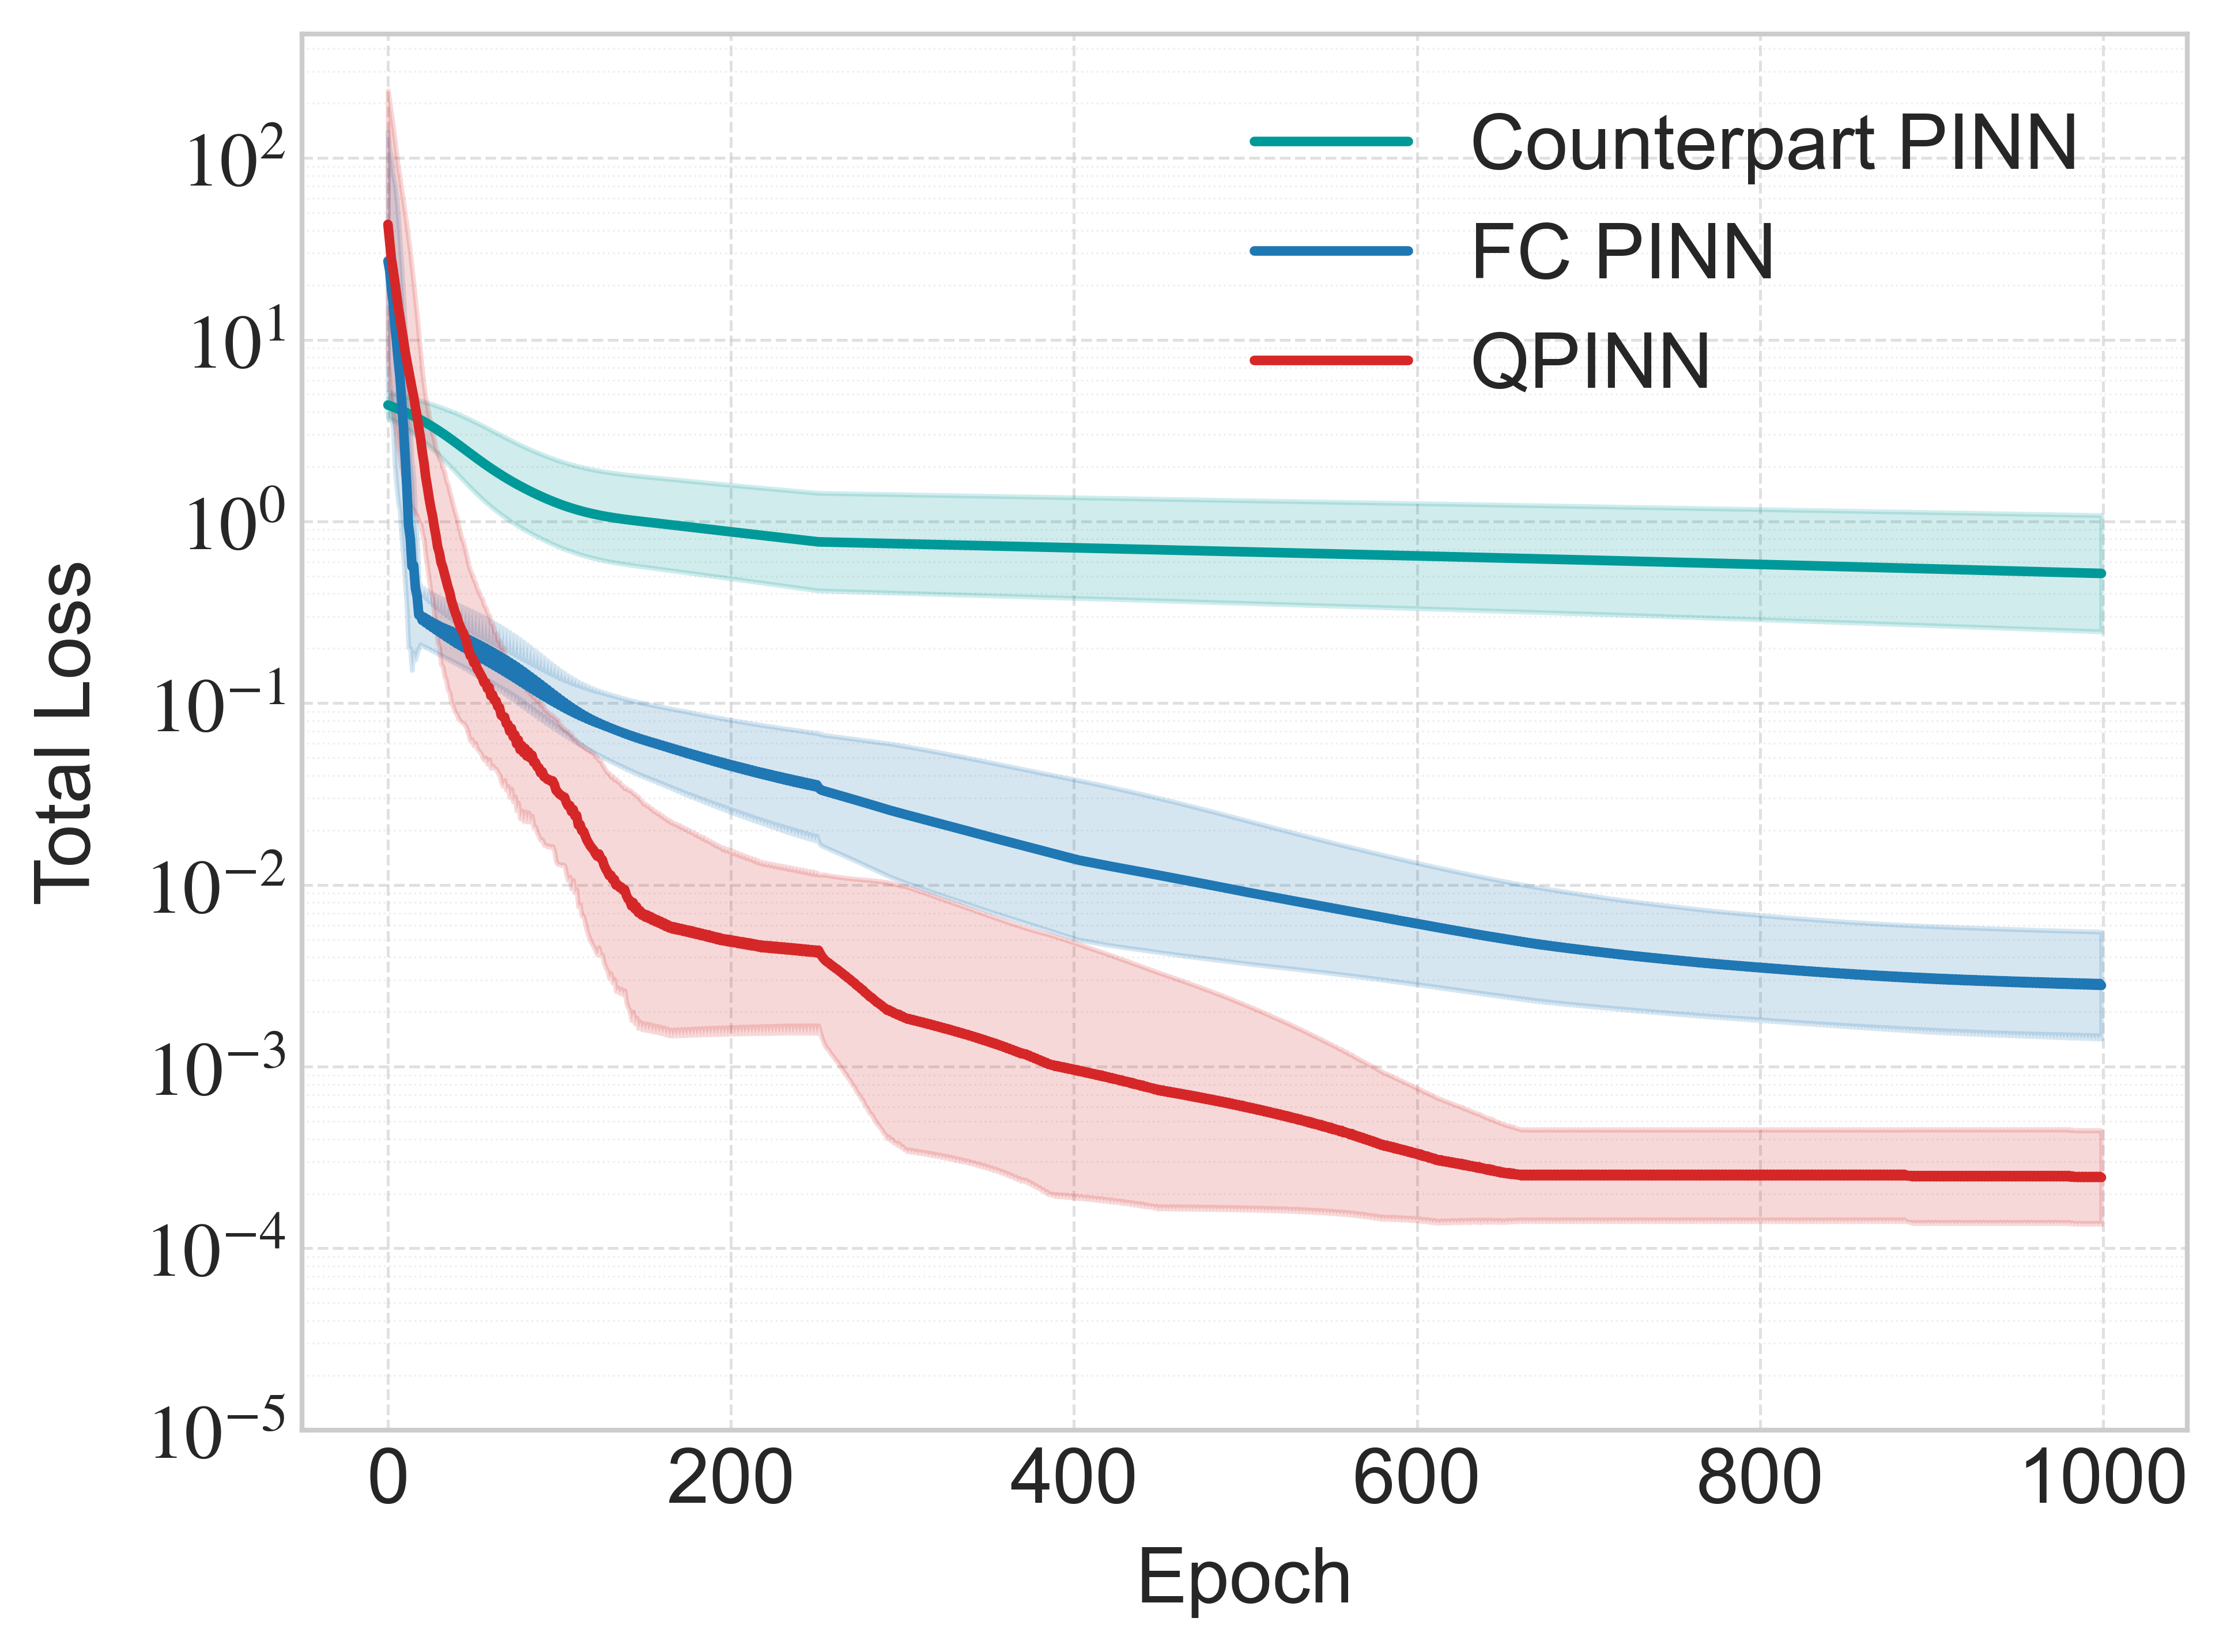

In [20]:
# ====== Adjustable parameters ======
runs = range(10)

# ====== Load data ======
losses_pinn = [np.load(f"results/run_{i}/losses_pinn.npy") for i in runs]
losses_qpinn = [np.load(f"results/run_{i}/losses_qpinn.npy") for i in runs]
losses_spinn = [np.load(f"results/run_{i}/losses_spinn.npy") for i in runs]

losses_pinn = np.array(losses_pinn)
losses_qpinn = np.array(losses_qpinn)
losses_spinn = np.array(losses_spinn)

# ====== Log-space mean and std ======
def log_mean_std(losses):
    # Avoid log(0)
    log_losses = np.log10(np.clip(losses, 1e-12, None))
    mean_log = np.mean(log_losses, axis=0)
    std_log = np.std(log_losses, axis=0)
    # Convert back to linear scale for plotting
    mean_lin = 10 ** mean_log
    lower = 10 ** (mean_log - std_log)
    upper = 10 ** (mean_log + std_log)
    return mean_lin, lower, upper

mean_pinn, lower_pinn, upper_pinn = log_mean_std(losses_pinn)
mean_qpinn, lower_qpinn, upper_qpinn = log_mean_std(losses_qpinn)
mean_spinn, lower_spinn, upper_spinn = log_mean_std(losses_spinn)

# ====== Plot setup ======
plt.figure(figsize=(7, 5), dpi=600)
plt.style.use('seaborn-v0_8-whitegrid')

colors = {
    "PINN": "#1f77b4",
    "QPINN": "#d62728",
    "SPINN": "#009999",
}

x = np.arange(len(mean_pinn))

def plot_with_log_std(mean, lower, upper, label, color):
    plt.plot(x, mean, label=label, color=color, linewidth=2)
    plt.fill_between(x, lower, upper, color=color, alpha=0.18)

# ====== Plot curves ======
plot_with_log_std(mean_spinn, lower_spinn, upper_spinn, "Counterpart PINN", colors["SPINN"])
plot_with_log_std(mean_pinn, lower_pinn, upper_pinn, "FC PINN", colors["PINN"])
plot_with_log_std(mean_qpinn, lower_qpinn, upper_qpinn, "QPINN", colors["QPINN"])

# ====== Log-scale y-axis ======
ax = plt.gca()
ax.set_yscale("log")
ax.set_ylim(bottom=1e-5)

# Show decades
ax.yaxis.set_major_locator(LogLocator(base=10.0, numticks=20))
ax.yaxis.set_minor_locator(LogLocator(base=10.0, subs=range(2, 10)))

# LaTeX tick format
ax.yaxis.set_major_formatter(
    FuncFormatter(lambda y, _: rf"$10^{{{int(np.log10(y))}}}$" if y > 0 else "")
)

# ====== Labels and styles ======
plt.xlabel("Epoch", fontsize=16, labelpad=6)
plt.ylabel("Total Loss", fontsize=16, labelpad=8)
plt.tick_params(axis='both', labelsize=16, width=1)

# ====== Legend (Right middle, large font) ======
plt.legend(
    fontsize=16,
    frameon=False,
    loc='center right',
    bbox_to_anchor=(0.98, 0.84)
)

# ====== Grid and layout ======
plt.grid(True, which="major", linestyle="--", linewidth=0.6, alpha=0.6)
plt.grid(True, which="minor", linestyle=":", linewidth=0.4, alpha=0.3)
plt.tight_layout(rect=[0, 0, 0.95, 1])

# ====== Save and show ======
plt.savefig("loss_comparison.png", bbox_inches="tight")
plt.show()


### Load data of models

In [10]:
# Load data files
index = 0
pinn_model.load_state_dict(torch.load("results/run_" + str(index) + "/pinn_model.pt"))
qpinn_model.load_state_dict(torch.load("results/run_" + str(index) + "/qpinn_model.pt"))
spinn_model.load_state_dict(torch.load("results/run_" + str(index) + "/spinn_model.pt"))


# -- Build the grid --
x_vals = np.linspace(0.01, 0.99, 50)
t_vals = np.linspace(0.01, 0.99, 50)
T_grid, X = np.meshgrid(t_vals, x_vals)

# Analytical solution
Y_true = np.exp(-k * (T - T_grid)) * X**gamma / gamma

X_flat = torch.tensor(X.flatten()[:, None], dtype=torch.float64)
T_flat = torch.tensor(T_grid.flatten()[:, None], dtype=torch.float64)

# QPINN prediction
with torch.no_grad():
    Y_q_flat = qpinn_model(T_flat, X_flat).cpu().numpy().flatten()
Y_q = Y_q_flat.reshape(T_grid.shape)

# PINN prediction
with torch.no_grad():
    Y_p_flat = pinn_model(T_flat, X_flat).cpu().numpy().flatten()
Y_p = Y_p_flat.reshape(T_grid.shape)

# SPINN prediction
with torch.no_grad():
    Y_s_flat = spinn_model(T_flat, X_flat).cpu().numpy().flatten()
Y_s = Y_s_flat.reshape(T_grid.shape)

### 3D Plot comparison

In [11]:
# ---------- simple global style ----------
rcParams.update({
    "font.family": "serif",
    "mathtext.fontset": "stix",
    "font.size": 16,
    "axes.labelsize": 26,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
    "axes.titlesize": 26,
    "figure.dpi": 300,
})

# ---------- shared z-range & surface kwargs ----------
ZMIN = np.min([Y_true.min(), Y_q.min(), Y_p.min(), Y_s.min()])
ZMAX = np.max([Y_true.max(), Y_q.max(), Y_p.max(), Y_s.max()])
surf_kwargs = dict(cmap="plasma", edgecolor="none", antialiased=True)

def tidy(ax, title, zlab, set_zlim=True):
    # camera similar to the reference figure
    ax.view_init(elev=28, azim=-55)
    # transparent panes & no grid lines
    for axis in (ax.xaxis, ax.yaxis, ax.zaxis):
        axis.set_pane_color((1, 1, 1, 1))
        axis._axinfo["grid"]["linewidth"] = 0.5
    # labels
    ax.set_title(title, pad=12)
    ax.set_xlabel(r"$x$", labelpad=10)
    ax.set_ylabel(r"$t$", labelpad=10)
    # ax.set_zlabel(zlab, labelpad=16)
    # ticks light and sparse
    ax.xaxis.set_ticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
    ax.yaxis.set_ticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
    if set_zlim:
        ax.set_zlim(ZMIN, 1.2)
    ax.set_box_aspect((1, 1, 0.7))
    ax.invert_xaxis()

fig = plt.figure(figsize=(18, 12), dpi=600)

# 1: Analytical
ax1 = fig.add_subplot(2, 2, 1, projection='3d')
ax1.plot_surface(X, T_grid, Y_true, **surf_kwargs)
tidy(ax1, r"Analytical solution", r"$f(x,t)$")

# 2: QPINN
ax2 = fig.add_subplot(2, 2, 2, projection='3d')
ax2.plot_surface(X, T_grid, Y_q, **surf_kwargs)
tidy(ax2, "QPINN Approximation", r"$v_{\mathrm{QPINN}}(t,x)$")

# 3: FC PINN
ax3 = fig.add_subplot(2, 2, 3, projection='3d')
ax3.plot_surface(X, T_grid, Y_p, **surf_kwargs)
tidy(ax3, "FC PINN Approximation", r"$v_{\mathrm{PINN}}(t,x)$")

# 4: SPINN
ax4 = fig.add_subplot(2, 2, 4, projection='3d')
ax4.plot_surface(X, T_grid, Y_s, **surf_kwargs)
tidy(ax4, "Counterpart PINN Approximation", r"$v_{\mathrm{SPINN}}(t,x)$")

plt.tight_layout(pad=1.0, w_pad=1.2, h_pad=1.2)
plt.savefig("3D_comparison_2x2.png", bbox_inches="tight")
plt.show()


### 2D comparison

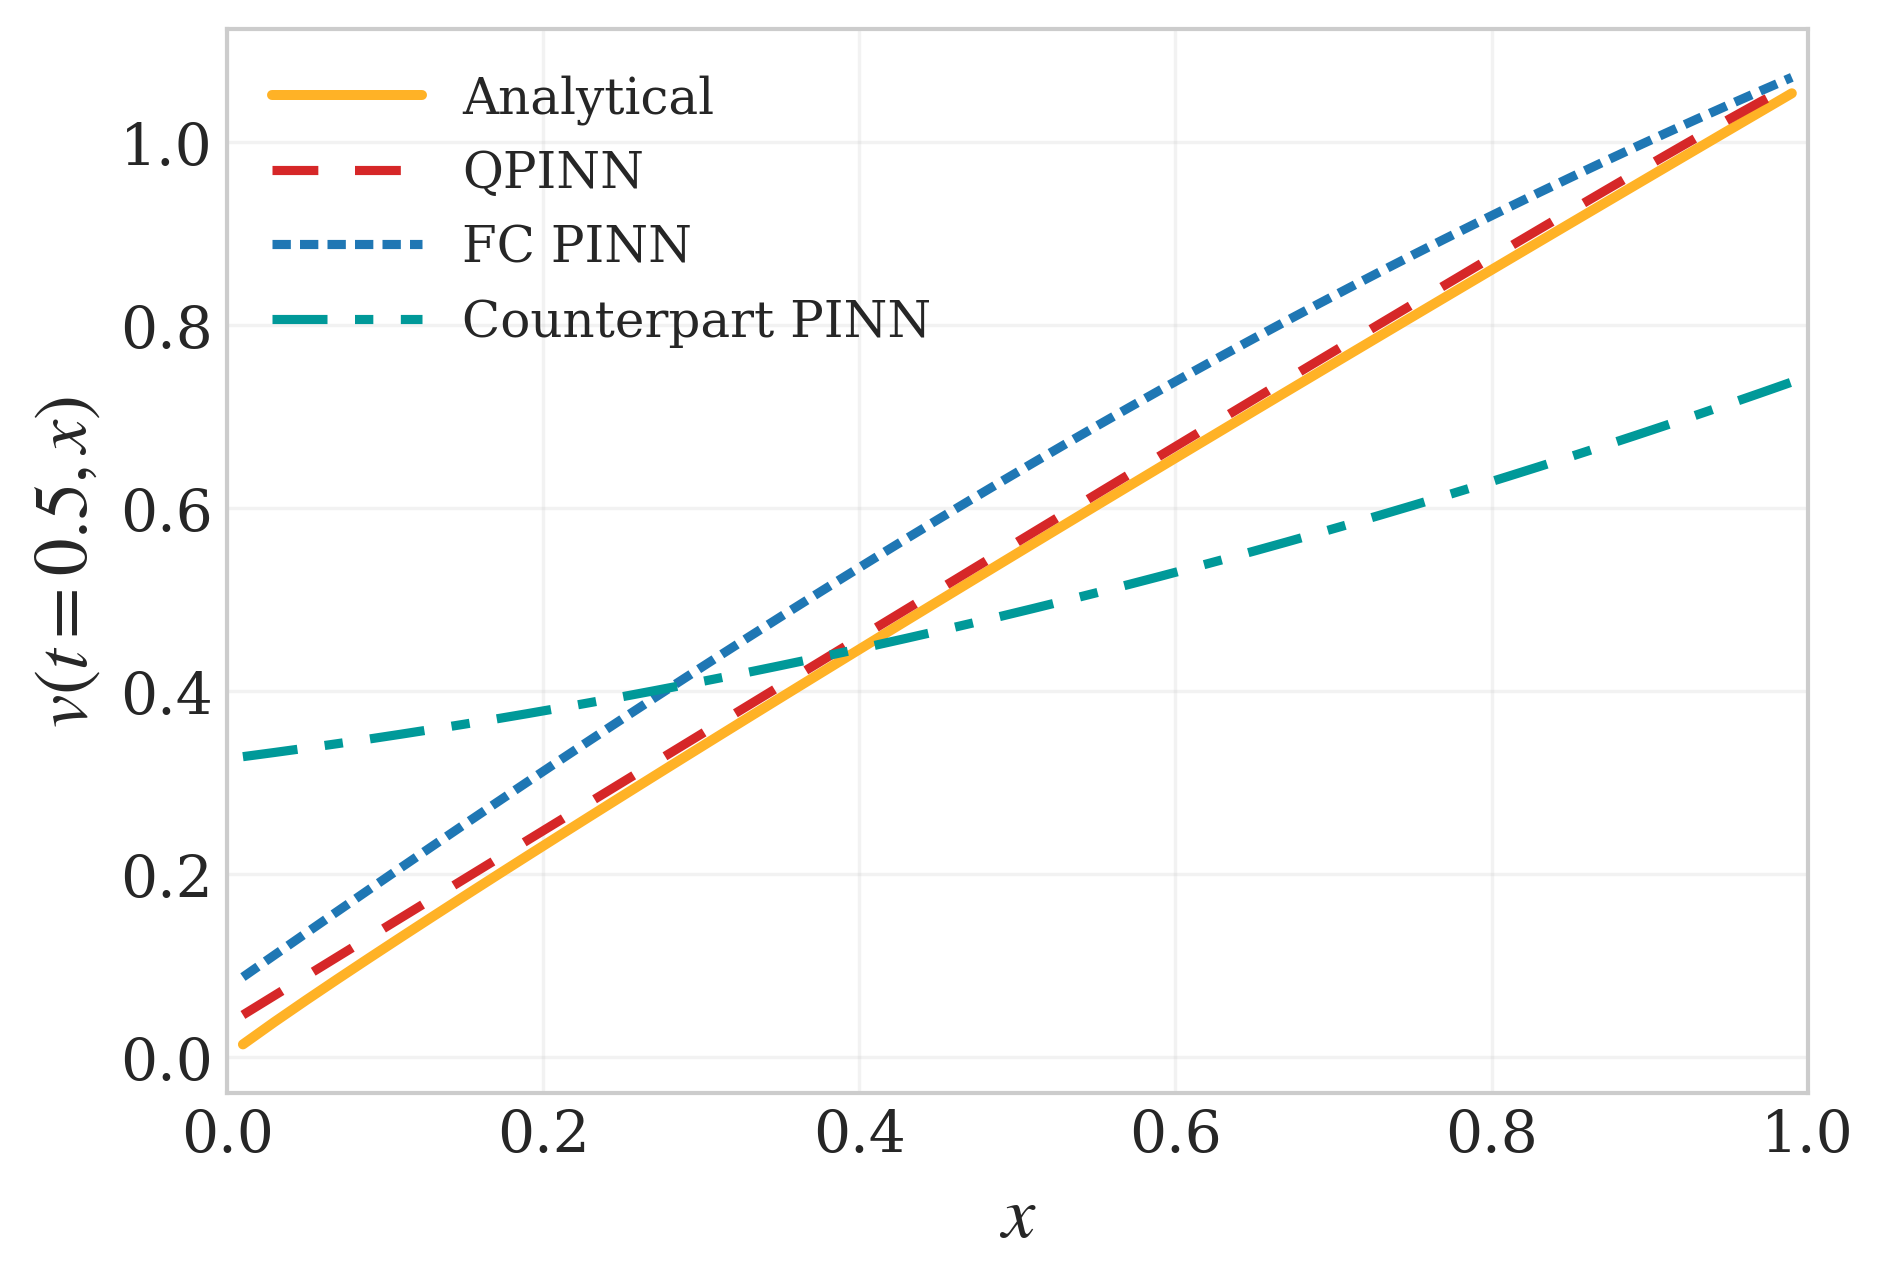

In [12]:
import numpy as np
import torch
import matplotlib.pyplot as plt

def to_np(a):
    if isinstance(a, torch.Tensor):
        a = a.detach().cpu().numpy()
    return a

def slice_at_t(X, T, Y, t0=0.5):
    """
    Extract a 1D slice of Y(t, x) at a fixed t = t0 using linear interpolation.
    Works for both (t,x) axis orientations.
    """
    X = to_np(X); T = to_np(T); Y = to_np(Y)
    assert X.shape == T.shape == Y.shape, "X, T_grid, and Y must have the same shape"

    # Detect which axis varies with t
    var0_t = np.nanmax(T[:, 0]) - np.nanmin(T[:, 0])
    var1_t = np.nanmax(T[0, :]) - np.nanmin(T[0, :])
    t_along_axis0 = var0_t > var1_t

    if t_along_axis0:
        t_axis = T[:, 0]
        x_axis = X[0, :]
        y_line = np.array([np.interp(t0, t_axis, Y[:, j]) for j in range(len(x_axis))])
    else:
        t_axis = T[0, :]
        x_axis = X[:, 0]
        y_line = np.array([np.interp(t0, t_axis, Y[i, :]) for i in range(len(x_axis))])

    order = np.argsort(x_axis)
    return x_axis[order], y_line[order]

# -------- Extract four curves at t = 0.5 --------
x_true, y_true = slice_at_t(X, T_grid, Y_true, t0=0.5)
x_q,    y_q    = slice_at_t(X, T_grid, Y_q,    t0=0.5)
x_p,    y_p    = slice_at_t(X, T_grid, Y_p,    t0=0.5)
x_s,    y_s    = slice_at_t(X, T_grid, Y_s,    t0=0.5)

# -------- Global style --------
plt.rcParams.update({
    "font.family": "serif",
    "mathtext.fontset": "stix",
    "font.size": 14,
    "axes.labelsize": 18,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
    "axes.titlesize": 18,
    "legend.fontsize": 12,
    "figure.dpi": 300,
})

# -------- Plot --------
plt.figure(figsize=(6.5, 4.5), dpi=300)

# Modern, balanced color palette
colors = ["#FFb226", "#d62728", "#1f77b4", "#009999"]

plt.plot(x_true, y_true, color=colors[0], linewidth=2.4, label="Analytical")
plt.plot(x_q, y_q, color=colors[1], linewidth=2.2, linestyle=(0, (5, 4)), label="QPINN")          # short dash
plt.plot(x_p, y_p, color=colors[2], linewidth=2.2, linestyle=(0, (2, 1)), label="FC PINN")        # dotted
plt.plot(x_s, y_s, color=colors[3], linewidth=2.2, linestyle=(0, (6, 3, 2, 3)), label="Counterpart PINN")  # dash-dot-dot

plt.xlabel(r'$x$')
plt.ylabel(r'$v(t=0.5, x)$')
# plt.title(r'Comparison at $t=0.5$')
plt.xlim(0, 1)
plt.grid(True, alpha=0.25)
plt.legend(frameon=False, handlelength=3)
plt.tight_layout()
plt.savefig("2D_comparison.png", bbox_inches="tight")
plt.show()
